In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
from plotting_fxns import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cmasher as cmr
%load_ext autoreload
%autoreload 2
sites = ['Z','T','EC','KPS']

In [83]:
site = 'Z'
glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
date = '09_16' # '09_09' if site == 'KPS' else '08_28'

ds = xr.open_dataset(f'../Data/{glacier.capitalize()}_2025_{date}_long{site}_climate.nc')
airtemp_daily = ds.temp.resample(time='d').mean()
df = pd.read_csv(f'../Data/{glacier}{site}_1d_forcings.csv',index_col=0)
df.index = pd.to_datetime(df.index)

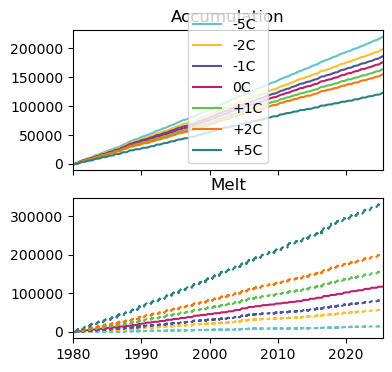

In [82]:
# # compare forcings
site = 'EC'
diff = '5C'
fig, axes = plt.subplots(2, figsize=(4, 4), sharex=True)
# for site in sites:
for d, diff in enumerate(['-5C','-2C','-1C','0C','+1C','+2C','+5C']):
# for d, diff in enumerate([0.5,0.667,0.9,1,1.1,1.5,2]):
    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    fn = f'../Data/{glacier}{site}_{diff}_1d_forcings.csv'
    df = pd.read_csv(fn, index_col=0)
    df.index = pd.to_datetime(df.index)
    axes[0].plot(df.index, df['BDOT'].cumsum(), label = str(diff), color=colors[d]) #diff[:-1])
    axes[1].plot(df.index, df['SMELT'].cumsum(), color=colors[d])
axes[0].legend()
axes[0].set_title('Accumulation')
axes[1].set_title('Melt')
axes[1].set_xlim(df.index[0], df.index[-1])
axes[1].set_xticks(pd.date_range('1980-01-01','2025-01-01',freq='10YS'))
axes[1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
plt.show()

In [85]:
# make varying temp/melt files
update_accum = True
df['AIRTEMP'] = airtemp_daily.sel(time=df.index).values
pdds = df['AIRTEMP'].copy(deep=True)
pdds.loc[pdds <= 0] = np.nan
melts = df['SMELT'].copy(deep=True)
ddf_avg = melts.sum() / pdds.sum()
ddf = melts / pdds
ddf_med = np.nanmedian(ddf)
ddf = ddf.fillna(ddf_avg)
print(ddf_avg, ddf_med)

# def rain_fraction(temp):
#     return np.clip((temp - 0.2) / (2.2 - 0.2), 0, 1)

# for temp_change in [-5, -2, -1, 1, 2, 5]:
#     temp_change_str = '+'+str(temp_change) if temp_change > 0 else temp_change
#     df_adj = df.copy(deep=True)
#     # ADJUST TEMPERATURE
#     df_adj['AIRTEMP'] += temp_change
#     # RECALCULATE MELT FROM PDDS
#     df_adj['PDDS'] = df_adj['AIRTEMP'].values
#     df_adj.loc[df_adj['PDDS'] < 0, 'PDDS'] = 0
#     df_adj['SMELT'] = df_adj['PDDS'] * ddf

#     if update_accum:
#         # TRACK TOTAL PRECIP
#         df_adj['PRECIP'] = df_adj['RAIN'] + df_adj['BDOT']
#         df_adj['RAIN_FRAC'] = rain_fraction(df_adj['AIRTEMP'])
#         # DAYS BELOW 0: CONVERT RAIN TO ACCUM, THEN REMOVE RAIN
#         df_adj['RAIN'] = df_adj['PRECIP'] * df_adj['RAIN_FRAC']
#         df_adj['BDOT'] = df_adj['PRECIP'] * (1 - df_adj['RAIN_FRAC'])
#         df_adj = df_adj.drop(columns=['AIRTEMP','PDDS','PRECIP','RAIN_FRAC'])
#         fn = f'../Data/{glacier}{site}_{temp_change_str}C_1d_forcings.csv'
#     else:
#         df_adj = df_adj.drop(columns=['AIRTEMP','PDDS'])
#         fn = f'../Data/{glacier}{site}_{temp_change_str}C_sameacc_1d_forcings.csv'
#     # PRINT CHANGES
#     sum_melt_change = np.sum(df_adj['SMELT'] - df['SMELT']) / 1000
#     sum_rain_change = np.sum(df_adj['RAIN'] - df['RAIN']) / 1000
#     sum_accum_change = np.sum(df_adj['BDOT'] - df['BDOT']) / 1000
#     print(temp_change, 'change in melt', sum_melt_change, 'change in rain', sum_rain_change, 'change in accum', sum_accum_change)
#     # STORE
#     df_adj.to_csv(fn)
# print(df_adj.head())

3.5363819589226257 3.3412190770101278


In [ ]:
# # make varying precip files
# for precip_change in [0.5, 0.667, 0.9, 1.1, 1.5, 2]:
#     df_adj = df.copy(deep=True)
#     # ADJUST ACCUMULATION
#     df_adj['BDOT'] *= precip_change
#     # PRINT CHANGES
#     sum_melt_change = np.sum(df_adj['SMELT'] - df['SMELT']) / 1000
#     sum_rain_change = np.sum(df_adj['RAIN'] - df['RAIN']) / 1000
#     sum_accum_change = np.sum(df_adj['BDOT'] - df['BDOT']) / 1000
#     print(precip_change, 'change in melt', sum_melt_change, 'change in rain', sum_rain_change, 'change in accum', sum_accum_change)
#     # STORE
#     df_adj = df_adj.drop(columns=['AIRTEMP'])
#     fn = f'../Data/{glacier}{site}_{precip_change}_1d_forcings.csv'
#     df_adj.to_csv(fn)
# print(df_adj.head())

0.5 change in melt 0.0 change in rain 0.0 change in accum -49.05878274409165
0.667 change in melt 0.0 change in rain 0.0 change in accum -32.67314930756504
0.9 change in melt 0.0 change in rain 0.0 change in accum -9.81175654881833
1.1 change in melt 0.0 change in rain 0.0 change in accum 9.811756548818341
1.5 change in melt 0.0 change in rain 0.0 change in accum 49.05878274409165
2 change in melt 0.0 change in rain 0.0 change in accum 98.1175654881833
                 BDOT  RAIN          TS     SMELT  SUBLIM
time                                                     
1980-04-15  48.415199   0.0  260.462500  0.129064     0.0
1980-04-16   3.312438   0.0  256.306250  0.295724     0.0
1980-04-17   0.354700   0.0  255.504167  0.535693     0.0
1980-04-18   6.869519   0.0  257.160417  0.406885     0.0
1980-04-19  20.888275   0.0  263.077083  0.146265     0.0


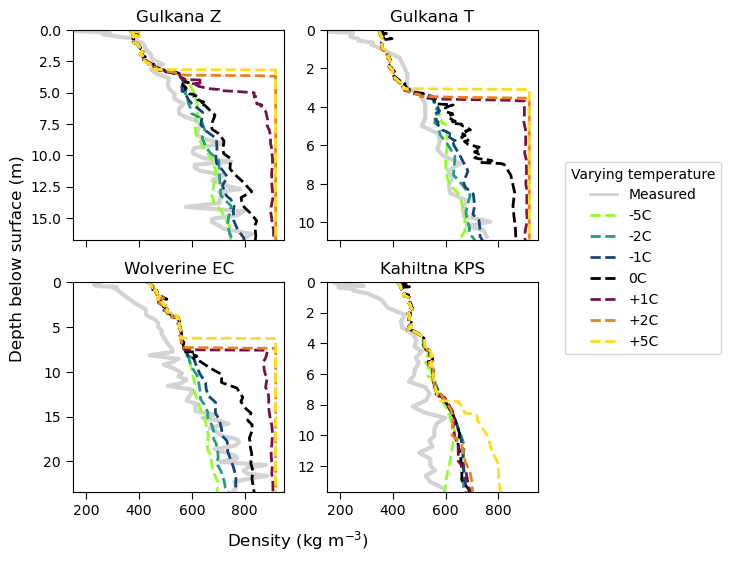

In [58]:
# MODELED DENSITY COMPARISON FOR CHANGING ACCUMULATION
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True) #,gridspec_kw={'hspace':0.4})
axes = axes.flatten()
change = 'temp'
updated_accum = True

sites = ['Z','T','EC','KPS'] # 
for s, site in enumerate(sites):
    ax = axes[s]
    all_measured = []
    all_modeled = []
    all_labels = []
    failed = []

    glacier = 'wolverine' if site == 'EC' else 'kahiltna' if site == 'KPS' else 'gulkana'
    date = dates_wolverine[-1] if site == 'EC' else dates_kahiltna[-1] if site == 'KPS' else '2025_04_20'
    density_meas, layer_tops, layer_bottoms = get_density_measured(site, date)

    if change == 'temp':
        change_factors = [-5, -2, -1, 0, 1, 2, 5]
    elif change == 'precip':
        change_factors = [0.5, 0.667, 0.9, 1, 1.1, 1.5, 2]
    for factor in change_factors:
        # Get labels
        if change == 'temp':
            factor_str = '+'+str(factor) if factor > 0 else str(factor)
            label = factor_str + 'C'
        elif change == 'precip':
            factor_str = str(factor)
            label = factor_str
        all_labels.append(label)

        if updated_accum or change == 'precip' or factor_str == 'GSFC2020':
            cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{factor_str}_0/CFMresults.hdf5'
        elif change == 'temp':
            cfm_fn = f'{glacier}{site}/CFMresults_{glacier}{site}_{factor_str}_sameacc_0/CFMresults.hdf5'
        if not os.path.exists(cfm_fn):
            failed.append((factor_str, site))
            print(factor_str, 'failed for site', site)
            modeled = ([np.nan], [np.nan])
        else:
            # load data
            modeled = get_var_modeled(cfm_fn, date, 'density')

        all_measured.append((density_meas, layer_bottoms, layer_tops))
        all_modeled.append(modeled)

    # plot
    axes[s] = simple_comparison(site, all_measured, all_modeled, all_labels, 
                                print_error=False,color_scheme='continuous', plot_ax = ax)
    axes[s].set_xlabel('')
    axes[s].set_ylabel('')
    axes[s].set_title(f'{glacier.capitalize()} {site}')

lax = fig.add_axes((1, 0.25, 0.15, 0.5))
lax.plot(np.nan, np.nan, color='lightgray',label='Measured', linewidth=2)
for i in range(len(change_factors)):
    cmap = cmr.wildfire
    norm = mpl.colors.Normalize(vmin=0, vmax=len(change_factors)-1)
    if i == 2:
        color = cmap(norm(1.4))
    if i == 4:
        color = cmap(norm(4.6))
    if i == 1:
        color = cmap(norm(0.7))
    if i == 5:
        color = cmap(norm(5.3))
    else:
        color = cmap(norm(i))
    lax.plot(np.nan, np.nan, color=color, label=all_labels[i],linestyle='--', linewidth=2)
lax.axis('off')
lax_title = 'Varying accumulation' if change == 'precip' else 'Varying temperature'
if not updated_accum:
    lax_title += '\nw/o changing accum'
lax.legend(fontsize=10, loc='center', title=lax_title)
fig.supxlabel('Density (kg m$^{-3}$)')
fig.supylabel('Depth below surface (m)')
# plt.savefig(f'../Data/{change}_change_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# END